# Necessary Weather Data

In this Jupyter notebook we note the necessary variables needed for PV production calculations. Moreover, we are going to list a series of possible weather databases.

## Weather databases

1. Meteonorm 8.1
2. PVGIS TMY
3. SOLCast TMY
4. Solar Anywhere TGY
5. Solargis TMY
6. NASA-SSE

## Weather variables to take into account

1. Global Horizontal Irradiance (GHI - kWh/m^2/month)
2. Horizontal Diffuse Radiation (DHI - kWh/m^2/month)
3. Temperature (celcius)
4. Wind velocity (m/s)
5. Linke turbidity (-)
6. Relative Humidity (%)

###### Side note on Linke Turbidity (TL)

Linke turbidity (TL) is really a lumped “haziness” index that accounts for all the extra extinction of sunlight beyond what a perfectly clean, dry atmosphere would do. That “extra extinction” comes mainly from two things:

Aerosols (pollution, dust, smoke, volcanic particles, etc.)
This is the “pollution” part. Urban smog or Saharan dust events push TL upward.

Water vapor absorption
Humid tropical air or summer days with high precipitable water also increase TL.

TL isn’t only a pollution indicator. A very humid but clean region (say, the Amazon) will also have a high TL even if the air is not polluted.

In [8]:
# Fetch hourly PVGIS SARAH-3 with pvlib (multi-year)
# pip install pvlib pandas pyarrow  (pyarrow optional for Parquet)

from __future__ import annotations
import datetime
import pathlib, time
import pandas as pd
import pvlib

LAT, LON = 41.9028, 12.4964
START_YEAR = 2011       
N_YEARS    = 12                
RADDATABASE = "PVGIS-SARAH3"
API_BASE = "https://re.jrc.ec.europa.eu/api/v5_3/"


def fetch_year(year: int) -> pd.DataFrame:
    """Return hourly PVGIS data (UTC index) with pvlib-mapped column names."""
    start, end = f"{year}-01-01", f"{year}-12-31"
    df, meta = pvlib.iotools.get_pvgis_hourly(
        LAT, LON,
        start=start, end=end,
        raddatabase=RADDATABASE,
        components=True,               # get GHI/DHI/DNI etc.
        surface_tilt=0, 
        surface_azimuth=0,  # horizontal
        usehorizon=True,
        map_variables=True,
        url=API_BASE,
        outputformat="json",
    )
    return df.sort_index()


all_years = []
for i in range(N_YEARS):
    y = START_YEAR + i
    print(f"Fetching {y} ({RADDATABASE}) …")
    for attempt in range(1, 4):
        try:
            dfx = fetch_year(y)
            dfx['TL'] = pvlib.clearsky.lookup_linke_turbidity(dfx.index, LAT, LON).values
            if dfx.index.tz is None or dfx.index.tz == datetime.timezone.utc:
                dfx.index = dfx.index.tz_convert("Europe/Rome")
            all_years.append(dfx)
            break
        except Exception as e:
            if attempt == 3:
                raise
            time.sleep(1.5 * attempt)



Fetching 2011 (PVGIS-SARAH3) …
Fetching 2012 (PVGIS-SARAH3) …
Fetching 2013 (PVGIS-SARAH3) …
Fetching 2014 (PVGIS-SARAH3) …
Fetching 2015 (PVGIS-SARAH3) …
Fetching 2016 (PVGIS-SARAH3) …
Fetching 2017 (PVGIS-SARAH3) …
Fetching 2018 (PVGIS-SARAH3) …
Fetching 2019 (PVGIS-SARAH3) …
Fetching 2020 (PVGIS-SARAH3) …
Fetching 2021 (PVGIS-SARAH3) …
Fetching 2022 (PVGIS-SARAH3) …


In [9]:
weather = pd.concat(all_years).sort_index()
weather.head()

,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,TL
time,,,,,,,,
2011-01-01 01:10:00+01:00,0.0,0.0,0.0,0.0,5.88,1.52,0,2.792742
2011-01-01 02:10:00+01:00,0.0,0.0,0.0,0.0,5.55,1.66,0,2.792742
2011-01-01 03:10:00+01:00,0.0,0.0,0.0,0.0,5.36,1.66,0,2.792742
2011-01-01 04:10:00+01:00,0.0,0.0,0.0,0.0,4.88,1.79,0,2.792742
2011-01-01 05:10:00+01:00,0.0,0.0,0.0,0.0,4.64,1.72,0,2.792742


#### Weather Data Preprocessing

pvgis returns poa_direct, poa_sky_diffuse, poa_ground_diffuse. To mimick pvsyst as much as possible, we are going to transform them into GHI, DHI, DNI. This is done via pvlib.

In [10]:
import pvlib

# --- build POA exactly as ModelChain expects (no transposition) ---
loc = pvlib.location.Location(LAT, LON, tz="Europe/Rome")
solpos = loc.get_solarposition(weather.index)

rev = pvlib.irradiance.gti_dirint(
    poa_global=weather['poa_direct']+weather['poa_sky_diffuse']+weather['poa_ground_diffuse'],
    aoi=pvlib.irradiance.aoi(0, 0, solpos['apparent_zenith'], solpos['azimuth']),
    solar_zenith=solpos['apparent_zenith'],
    solar_azimuth=solpos['azimuth'],
    times=weather.index,
    surface_tilt=0,
    surface_azimuth=0,
)
weather[['ghi','dni','dhi']] = rev[['ghi','dni','dhi']]
weather.head()

c:\dev\data-analisys\notes-on-pvlib\venv\lib\site-packages\pvlib\irradiance.py:2515: RuntimeWarning: 1518 points failed to converge after 30 iterations. best_diff:
time
2011-01-22 17:10:00+01:00    9999.0
2011-01-23 17:10:00+01:00    9999.0
2011-01-24 17:10:00+01:00    9999.0
2011-01-25 17:10:00+01:00    9999.0
2011-01-26 17:10:00+01:00    9999.0
                              ...  
2022-11-18 07:10:00+01:00    9999.0
2022-11-19 07:10:00+01:00    9999.0
2022-11-20 07:10:00+01:00    9999.0
2022-11-21 07:10:00+01:00    9999.0
2022-11-22 07:10:00+01:00    9999.0
Length: 1518, dtype: float64
  warnings.warn(


,poa_direct,poa_sky_diffuse,poa_ground_diffuse,solar_elevation,temp_air,wind_speed,Int,TL,ghi,dni,dhi
time,,,,,,,,,,,
2011-01-01 01:10:00+01:00,0.0,0.0,0.0,0.0,5.88,1.52,0,2.792742,NaN,NaN,NaN
2011-01-01 02:10:00+01:00,0.0,0.0,0.0,0.0,5.55,1.66,0,2.792742,NaN,NaN,NaN
2011-01-01 03:10:00+01:00,0.0,0.0,0.0,0.0,5.36,1.66,0,2.792742,NaN,NaN,NaN
2011-01-01 04:10:00+01:00,0.0,0.0,0.0,0.0,4.88,1.79,0,2.792742,NaN,NaN,NaN
2011-01-01 05:10:00+01:00,0.0,0.0,0.0,0.0,4.64,1.72,0,2.792742,NaN,NaN,NaN


# PV plant anagraphics definition

We are now going to take into account the specifics of the PV plant. In particular, the mounting configuration, the PV tracking configuration, the cell temperature model according to pvsyst's practices.

In [27]:
cecm = pvlib.pvsystem.retrieve_sam('cecmod')
ceci = pvlib.pvsystem.retrieve_sam('cecinverter')
module = cecm[cecm.columns[0]]
module['K'] = module.get('K', 0.05)
inverter = ceci[ceci.columns[0]]


TRACKING_TYPE = "two_axis"  # "fixed" | "single_axis" | "two_axis"
RACKING_MODEL = "open_rack"  # "open_rack" or "close_mount" (used for temp/IAM conventions)
FIXED_TILT = 0
FIXED_AZIMUTH = 0
AXIS_TILT = 0.0
AXIS_AZIMUTH = 180.0       # N-S axis: 0 or 180 (pvlib uses degrees from North, CW)
MAX_ANGLE = 60.0
BACKTRACK = False
GCR = 0.35
U_C, U_V = (29.0, 0.0) if RACKING_MODEL == "open_rack" else (20.0, 6.0)

eta_m = float(module['I_mp_ref']*module['V_mp_ref']) / (1000.0 * float(module['A_c']))

temperature_model_parameters = dict(u_c=U_C, u_v=U_V, eta_m=eta_m, alpha_absorption=0.9)

In [ ]:
if TRACKING_TYPE == 'single_axis':
    mount = pvlib.pvsystem.SingleAxisTrackerMount(
        gcr=GCR,
        backtrack=BACKTRACK,
        max_angle=MAX_ANGLE,
        axis_azimuth=AXIS_AZIMUTH
    )
    array = pvlib.pvsystem.Array(
        mount,
        module_parameters=module,
        # modules_per_string=modules_per_string,
        temperature_model_parameters=temperature_model_parameters,
        # strings=strings_per_inverter
    )
    system = pvlib.pvsystem.PVSystem(
        array,
        inverter_parameters=inverter,
        albedo=0.2,
        # losses_parameters=losses_parameters
    )

In [29]:
from models.pv_custom.dual_axis_tracker_mount import DualAxisTrackerMount


if TRACKING_TYPE == 'two_axis':
    array = pvlib.pvsystem.Array(
        mount=DualAxisTrackerMount(),
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters
    )
    system = pvlib.pvsystem.PVSystem(
        array,
        module_parameters=module,
        inverter_parameters=inverter,
        albedo=0.2,
    )

# Power Output Calculation

In [30]:
if TRACKING_TYPE == "fixed":
    system = pvlib.pvsystem.PVSystem(
        surface_tilt=FIXED_TILT,
        surface_azimuth=FIXED_AZIMUTH,
        module_parameters=module,
        inverter_parameters=inverter,
        temperature_model_parameters=temperature_model_parameters,
        racking_model=RACKING_MODEL,
        albedo=0.2,
    )


mc_kwargs = dict(
    aoi_model='ashrae',        # closer to many PVSyst projects
    spectral_model='no_loss',
    temperature_model='pvsyst',
    transposition_model='perez',
    losses_model='pvwatts',
)
orientation_strategy = None
if TRACKING_TYPE == "two_axis":
    orientation_strategy = 'two-axis'
mc = pvlib.modelchain.ModelChain(
    system, 
    loc, 
    # orientation_strategy=orientation_strategy, 
    **mc_kwargs
    )

mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: perez
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: ashrae_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: pvsyst_temp
  losses_model: pvwatts_losses

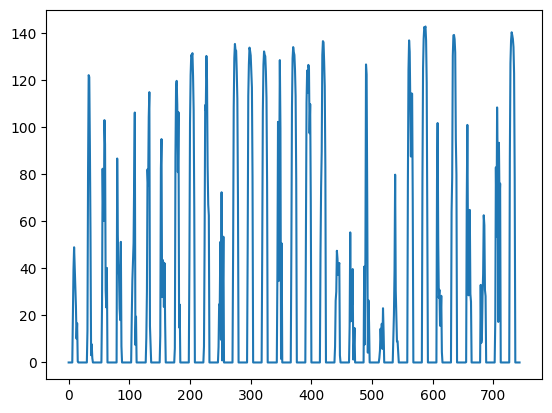

In [32]:
import matplotlib.pyplot as plt

plt.plot(mc.results.ac.values[0:744])